In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [54]:
N = 1000
S0 = 100
T = 1
n = 100
sigma0 = 0.4
lamda = 2
c = 0.4
gamma = 0.3
r= 0.02

In [55]:
def sigma_simu(T,N,n,sigma0,lamda,c,gamma):
    dt = T/n
    Z = np.random.randn(N,n)
    dW = Z * np.sqrt(dt)
    sigma = np.zeros((N,n+1)) 
    sigma[:,0] = sigma0
    for i in range(1,n+1):
        sigma[:,i] = sigma[:,i-1] + lamda *(c - sigma[:,i-1])*dt + gamma* dW[:,i-1]
    return sigma

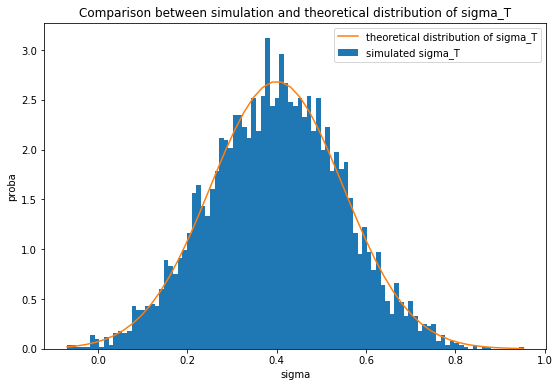

In [56]:
# sanity check
def theoretical_sigma_T(sigma0,lamda, c, gamma, T):
    mean = sigma0*np.exp(-lamda*T) + c*(1-np.exp(-lamda*T))
    var = gamma**2/(2*lamda)*(1-np.exp(-2*lamda*T))
    std = np.sqrt(var)
    return  mean, std

sigma =sigma_simu(T,5000,n,sigma0,lamda,c,gamma)
mean, std = theoretical_sigma_T(sigma0,lamda, c, gamma, T)
left = min(sigma[:,-1])
right = max(sigma[:,-1])
xx = np.linspace(left,right)
sigma_therotical = sts.norm.pdf(xx,mean,std)
plt.figure(figsize=(9,6))
plt.hist(sigma[:,-1], bins= int(N**(2/3)), label = "simulated sigma_T", normed=True)
plt.plot(xx, sigma_therotical, label = "theoretical distribution of sigma_T")
plt.legend(loc = 'best')
plt.xlabel("sigma")
plt.ylabel("proba")
plt.title("Comparison between simulation and theoretical distribution of sigma_T")
plt.show()

# Check
$$ \sigma_{T} = \sigma_0 e^{-\lambda T}+c(1 - e^{-\lambda T}) + \gamma e^{-\lambda T} \int_0^T e^{\lambda t} dW_t $$
By comparing the simulated sigma_T and theoretical sigma_T, we see the distribution of simulated sigma_T corresponds to the theoretical distribution. Thus, the simulation of sigma is correct

In [57]:
def S_simu(T,N,n,sigma,S0):
    dt = T/n
    Z = np.random.randn(N,n)
    dW = Z * np.sqrt(dt)
    term1 = -0.5*np.cumsum(sigma[:,:-1]**2 *dt, axis = 1)
    term2 = np.cumsum(sigma[:,:-1]*dW, axis = 1)
    S = S0*np.exp(term1 + term2)
    S = np.concatenate((np.ones((N,1)), S), axis = 1)
    return S


In [58]:
def d_plus(sigma,T,t,S,K,r):
    return 1./(sigma*np.sqrt(T-t))*(np.log(S/K)+(r+sigma*sigma/2.)*(T-t))

def Gamma_BS(sigma,T,t,S,K,r):
    return 1/(S*sigma*np.sqrt(T-t))* sts.norm.pdf(d_plus(sigma,T,t,S,K,r))

def PnL(T,N,n,sigma0,K,r,S,sigma):
    gamma_BS = np.zeros((N,n))
    dt = T/n
    tt = np.arange(n)*dt
    for i in range(n):
        gamma_BS[:,i] = Gamma_BS(sigma0,T,i*dt,S[:,i],K,r)
    PL = 0.5*np.exp(r*T)*np.sum(np.exp(-r*tt)*(sigma0**2 - sigma[:,:-1]**2)*S[:,:-1]**2 *gamma_BS*dt, axis = 1)
    return PL


In [59]:
nn = np.arange(50,110,10)
K = np.arange(5,151) + 100
PnL_mean = []
PnL_var = []
for n in nn:
    print("simulating for n = {}".format(n))
    PnL_mean.append([])
    PnL_var.append([])
    sigma = sigma_simu(T,N,n,sigma0,lamda,c,gamma)
    S = S_simu(T,N,n,sigma,S0)
    for k in K:
        PL = PnL(T,N,n,sigma0,k,r,S,sigma)
        PnL_mean[-1].append(np.mean(PL))
        PnL_var[-1].append(np.var(PL))
        
        

simulating for n = 50
simulating for n = 60
simulating for n = 70
simulating for n = 80
simulating for n = 90
simulating for n = 100


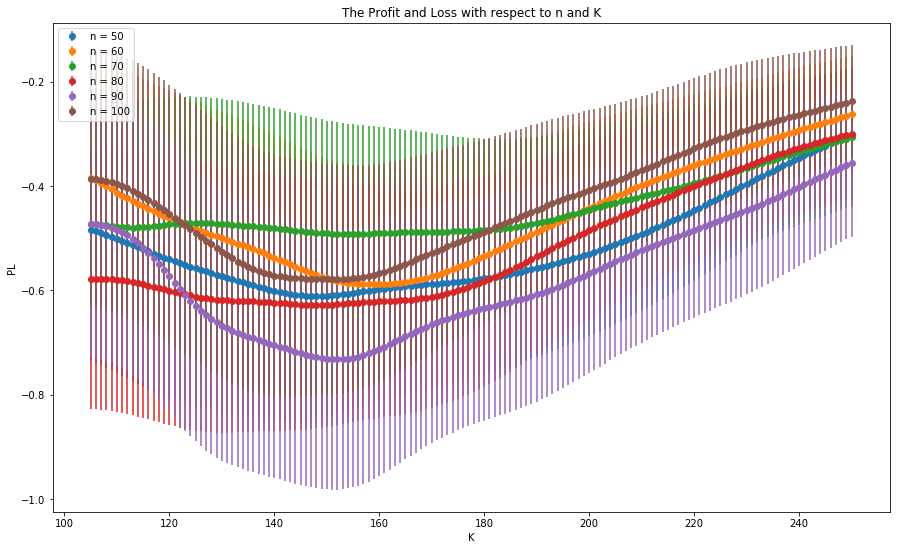

In [60]:
plt.figure(figsize=(15,9))
for i in range(len(nn)):
    plt.errorbar(x=K, y=PnL_mean[i],yerr=[np.sqrt(j/N)*1.96 for j in PnL_var[i]], fmt = 'o', 
                    label = "n = "+str(nn[i]) )
plt.title("The Profit and Loss with respect to n and K")
plt.xlabel("K")
plt.ylabel("PL")
plt.legend(loc = "best")
plt.show()

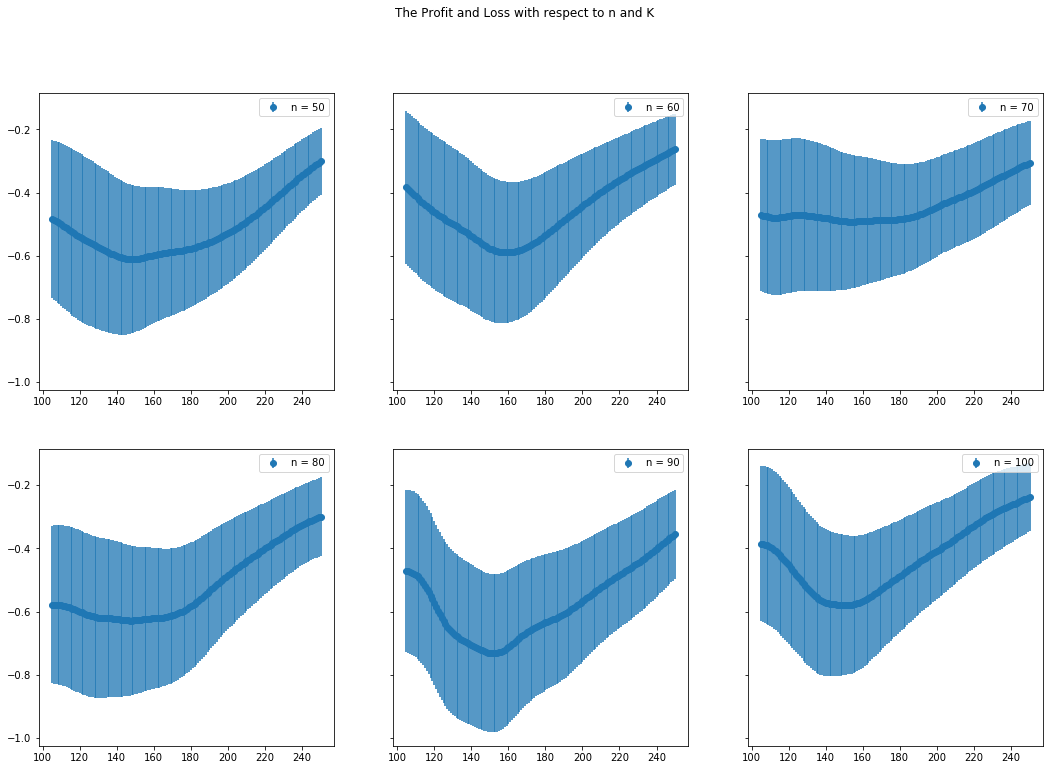

In [61]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
for i in range(len(nn)):
    axs[i//3][i%3].errorbar(x=K, y=PnL_mean[i],yerr=[np.sqrt(j/N)*1.96 for j in PnL_var[i]], fmt = 'o', 
                    label = "n = "+str(nn[i]) )
    #axs[i//3][i%3].xlabel("K")
    #axs[i//3][i%3].ylabel("PL")
    axs[i//3][i%3].legend()
fig.suptitle("The Profit and Loss with respect to n and K")
plt.show()

# Conclusion
## 1
As proposition 9.3 of the textbook suggests, PnL is positive if constant sigma is always greater than actual sigma. As the actual sigma follows an Ornstein-Uhlenbeck processm, it will eventually get back to its mean with some oscillation. Thus, the condition of proposition 9.3 is violated and PnL cannot be always greater than 0.  

## 2
As we know, the Black-Scholes formula is based on the hypothesis of constant volatility, which is violated here. The volatility actually follows an Ornstein-Uhlenbeck process. Thus, the hedge taken by the trader cannot be garanted correct. Therefore, if one seller hedge his portofolio with constant volatility, it is possible that he can not fully hedge his position and thus generate a loss at maturity. 

## 3
With different n, the tendences of PnL are the same. They tend to drop when K increases at first. Then, when the option is getting into deep out of the money, that is to say, when the K is very high, the PnL increase and get back to near 0. This phenomenon can be explained by the low hedging frequency for deep out of money option. When the option is deep out of money, the trader do not need to hedge the position very frequently since gamma is small. Therefore, this low hedging frequency helps lower the cumulated error in hedging.
